In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Download and Data preprocessing

In [3]:
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/train.txt" -o "train.txt"
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/valid.txt" -o "valid.txt"
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/test.txt" -o "test.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3206k  100 3206k    0     0  6822k      0 --:--:-- --:--:-- --:--:-- 6807k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  808k  100  808k    0     0  2282k      0 --:--:-- --:--:-- --:--:-- 2282k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  730k  100  730k    0     0  1660k      0 --:--:-- --:--:-- --:--:-- 1656k


We'll use fastText for word embedding.

In [4]:
fasttext_path = "/gdrive/MyDrive/Colab Notebooks/ConLL-NER/bin/crawl-300d-2M.vec"

In [5]:
!head -5 train.txt

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC


In [6]:
import nltk
from nltk.corpus.reader import ConllCorpusReader

In [7]:
train_sentences = ConllCorpusReader("./", "train.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()
valid_sentences = ConllCorpusReader("./", "valid.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()
test_sentences = ConllCorpusReader("./", "test.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()

Remove empty (len = 0) sentences due to data error.

In [8]:
train_sentences = [s for s in train_sentences if len(s) > 0]
valid_sentences = [s for s in valid_sentences if len(s) > 0]
test_sentences = [s for s in test_sentences if len(s) > 0]

In [9]:
print(f"Length of train set: {len(train_sentences)}")
print(f"Length of validation set: {len(valid_sentences)}")
print(f"Length of test set: {len(test_sentences)}")

Length of train set: 14041
Length of validation set: 3250
Length of test set: 3453


In [10]:
train_sentences[0]

[('EU', 'NNP', 'B-ORG'),
 ('rejects', 'VBZ', 'O'),
 ('German', 'JJ', 'B-MISC'),
 ('call', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('boycott', 'VB', 'O'),
 ('British', 'JJ', 'B-MISC'),
 ('lamb', 'NN', 'O'),
 ('.', '.', 'O')]

In [11]:
valid_sentences[0]

[('CRICKET', 'NNP', 'O'),
 ('-', ':', 'O'),
 ('LEICESTERSHIRE', 'NNP', 'B-ORG'),
 ('TAKE', 'NNP', 'O'),
 ('OVER', 'IN', 'O'),
 ('AT', 'NNP', 'O'),
 ('TOP', 'NNP', 'O'),
 ('AFTER', 'NNP', 'O'),
 ('INNINGS', 'NNP', 'O'),
 ('VICTORY', 'NN', 'O'),
 ('.', '.', 'O')]

In [12]:
test_sentences[0]

[('SOCCER', 'NN', 'O'),
 ('-', ':', 'O'),
 ('JAPAN', 'NNP', 'B-LOC'),
 ('GET', 'VB', 'O'),
 ('LUCKY', 'NNP', 'O'),
 ('WIN', 'NNP', 'O'),
 (',', ',', 'O'),
 ('CHINA', 'NNP', 'B-PER'),
 ('IN', 'IN', 'O'),
 ('SURPRISE', 'DT', 'O'),
 ('DEFEAT', 'NN', 'O'),
 ('.', '.', 'O')]

Format the data to (token, chunk)

In [13]:
def create_data(dataset):
    data = []
    label = []
    for sentence in dataset:
        current_data = []
        current_label = []
        
        for token, _, chunk in sentence:
            current_data.append(token.lower())
            current_label.append(chunk)
        
        data.append(current_data)
        label.append(current_label)

    return data, label

In [14]:
train_data, train_labels = create_data(train_sentences)
val_data, val_labels = create_data(valid_sentences)
test_data, test_labels = create_data(test_sentences)

In [15]:
train_data[0], train_labels[0]

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

In [16]:
val_data[0], val_labels[0]

(['cricket',
  '-',
  'leicestershire',
  'take',
  'over',
  'at',
  'top',
  'after',
  'innings',
  'victory',
  '.'],
 ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [17]:
test_data[0], test_labels[0]

(['soccer',
  '-',
  'japan',
  'get',
  'lucky',
  'win',
  ',',
  'china',
  'in',
  'surprise',
  'defeat',
  '.'],
 ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O'])

## Create dataset

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

In [19]:
class ConLLDataset(Dataset):
    def __init__(self, sentences, labels):
        super().__init__()
        
        self.sentences = sentences
        self.labels = labels
    
        self.length = len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]
    
    def __len__(self):
        return self.length

In [20]:
train_dataset = ConLLDataset(train_data, train_labels)
val_dataset = ConLLDataset(val_data, val_labels)

In [21]:
next(iter(train_dataset))

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

In [22]:
next(iter(val_dataset))

(['cricket',
  '-',
  'leicestershire',
  'take',
  'over',
  'at',
  'top',
  'after',
  'innings',
  'victory',
  '.'],
 ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

Build vocabulary from given dataset (training only!)

In [23]:
from torchtext.vocab import build_vocab_from_iterator

In [24]:
def yield_tokens(data_iter):
    for sentence, label in data_iter:
        yield sentence

In [25]:
vocabulary = build_vocab_from_iterator(yield_tokens(iter(train_dataset)), specials = ["<pad>", "<unk>"])
vocabulary.set_default_index(vocabulary["<pad>"])

In [26]:
vocabulary["<pad>"], vocabulary["<unk>"]

(0, 1)

In [27]:
len(vocabulary)

21011

In [28]:
vocabulary(next(iter(train_dataset))[0])

[1004, 18979, 205, 637, 7, 4083, 216, 6755, 3]

In [29]:
vocabulary(next(iter(val_dataset))[0])

[293, 18, 2535, 265, 73, 19, 392, 42, 286, 312, 3]

## Labels encoding

In [30]:
unique_labels = list({x for l in train_labels for x in l})

In [31]:
unique_labels

['I-MISC', 'B-ORG', 'I-LOC', 'O', 'B-PER', 'B-LOC', 'I-ORG', 'B-MISC', 'I-PER']

In [32]:
label2idx = {label : idx for idx, label in enumerate(unique_labels)}
idx2label = {idx : label for idx, label in enumerate(unique_labels)}

In [33]:
label2idx["B-ORG"], idx2label[1]

(1, 'B-ORG')

Using Seq2Seq requires similar length in both input and output. Hence we'll need a small analysis on the data length to determine the max length.

In [34]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


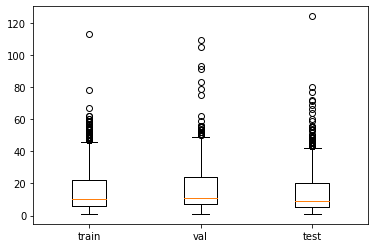

In [35]:
d = {"train" : [len(s) for s in train_data], "val" : [len(s) for s in val_data], "test" : [len(s) for s in test_data]}

fig, ax = plt.subplots()

ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
plt.show()

Except some sentences are 100-120 tokens length, we can use 64 tokens for a sentence.

In [36]:
MAX_SEQ_LENGTH = 64

In [37]:
def pad_sequence(sequence):
    padded_sequences = np.zeros((len(sequence),), dtype = float)
    
    current_len = len(sequence)

    if current_len <= MAX_SEQ_LENGTH:
        zeroes = list(np.zeros(MAX_SEQ_LENGTH - current_len))
        new = sequence + zeroes

    elif current_len > MAX_SEQ_LENGTH:
        new = sequence[0:MAX_SEQ_LENGTH]
        
    return new

In [38]:
vectorized_sample = vocabulary(next(iter(train_dataset))[0])
pad_sequence(vectorized_sample)

[1004,
 18979,
 205,
 637,
 7,
 4083,
 216,
 6755,
 3,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [39]:
from tqdm import tqdm_notebook

In [40]:
def load_pretrained_vectors(word2idx, fname):
    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype='float')

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [41]:
# Load embedding
embeddings = load_pretrained_vectors(vocabulary, fasttext_path)
embeddings = torch.tensor(embeddings, dtype=torch.float)

Loading pretrained vectors...


<ipython-input-40-1a7e13dfb854>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 16937 / 21011 pretrained vectors found.


In [42]:
embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0912,  0.1388, -0.1951,  ..., -0.0343,  0.0220, -0.1382],
        [ 0.0231,  0.0170,  0.0157,  ...,  0.0744, -0.1118,  0.0963],
        ...,
        [-0.2395,  0.1144, -0.1171,  ..., -0.2035, -0.1288, -0.0770],
        [ 0.3446, -0.4639,  0.6707,  ...,  0.2111, -0.0163,  0.1816],
        [-0.0407,  0.1726,  0.5130,  ...,  0.5594, -0.1172, -0.1871]])

Create a dataloader

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
def collate_batch(batch):
    sentences, labels = [], []
    
    for (sentence, label) in batch:
        sentence_tensor = torch.tensor(vocabulary(sentence), dtype = torch.long)
        sentences.append(sentence_tensor)
        
        label = torch.tensor([label2idx[l] for l in label], dtype = torch.long)
        labels.append(label)
    
    
    sentences = torch.cat(sentences)
    labels = torch.cat(labels)
    
    
    return sentences.to(device), labels.to(device)

# Model

## Module class

In [45]:
class ConLLNER_GRU(torch.nn.Module):
    def __init__(self, pretrained_embedding=None, freeze_embedding=True, vocab_size = None, embedding_dim = None, hidden_size=64, output_dim=64, num_layers=4):
        super().__init__()
        
        self.output_dim = output_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if pretrained_embedding is not None:
            self.vocab_size, self.embedding_dim = pretrained_embedding.shape

            self.embedding = torch.nn.Embedding.from_pretrained(
                embeddings=pretrained_embedding,
                freeze=freeze_embedding
            )
        else:
            self.vocab_size = vocab_size
            self.embedding_dim = embedding_dim

            self.embedding = torch.nn.Embedding(
                num_embeddings = self.vocab_size,
                embedding_dim = self.embedding_dim
            )

        self.gru = torch.nn.GRU(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            bidirectional = True
        )
        
        self.fc = torch.nn.Linear(
            in_features = self.hidden_size * 2,
            out_features = self.output_dim
        )
    
    def forward(self, sentence):
        embedded = self.embedding(sentence)
        
        rnn_output, _ = self.gru(embedded.view(len(sentence), 1, -1))
        tag_space = self.fc(rnn_output.view(len(sentence), -1))
        tag_scores = torch.nn.functional.log_softmax(tag_space, dim = 1)

        return tag_scores
        

## Hyperparameters

In [46]:
batch_size = 64
epochs = 100
learning_rate = .001

vocab_size = len(vocabulary)
embedding_dim = 64
hidden_size = 64
num_layers = 4
output_dim = len(unique_labels)

# Training

## Warmup

In [47]:
model_bigru_fasttext_freezed = ConLLNER_GRU(
    pretrained_embedding=embeddings,
    freeze_embedding=True,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

model_bigru_fasttext_trainable = ConLLNER_GRU(
    pretrained_embedding=embeddings,
    freeze_embedding=False,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

model_bigru = ConLLNER_GRU(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

In [48]:
# Loss function
loss_fn = torch.nn.NLLLoss()

# Optimizer
optimizer_rand = torch.optim.Adam(model_bigru.parameters(), lr = learning_rate)
optimizer_fasttext_freezed = torch.optim.Adam(model_bigru_fasttext_freezed.parameters(), lr = learning_rate)
optimizer_fasttext_trainable = torch.optim.Adam(model_bigru_fasttext_trainable.parameters(), lr = learning_rate)

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)

Print some examples

In [50]:
with torch.no_grad():
    inputs = next(iter(train_dataloader))
    tag_scores_random = model_bigru(inputs[0])
    print(tag_scores_random)

    tag_scores_fasttext_freezed = model_bigru_fasttext_freezed(inputs[0])
    print(tag_scores_fasttext_freezed)

    tag_scores_fasttext_trainable = model_bigru_fasttext_trainable(inputs[0])
    print(tag_scores_fasttext_trainable)

tensor([[-2.3135, -2.0978, -2.1113,  ..., -2.1857, -2.1594, -2.2903],
        [-2.3087, -2.0931, -2.0962,  ..., -2.1931, -2.1578, -2.3283],
        [-2.3056, -2.0942, -2.0908,  ..., -2.1887, -2.1488, -2.3447],
        ...,
        [-2.3055, -2.1575, -2.1086,  ..., -2.1398, -2.1437, -2.4042],
        [-2.2896, -2.1325, -2.1369,  ..., -2.1288, -2.1653, -2.3947],
        [-2.2563, -2.1183, -2.1640,  ..., -2.1003, -2.1997, -2.3775]],
       device='cuda:0')
tensor([[-2.1106, -2.2370, -2.2729,  ..., -2.1552, -2.2508, -2.2311],
        [-2.1211, -2.2105, -2.3121,  ..., -2.1439, -2.2488, -2.2187],
        [-2.1253, -2.1773, -2.3398,  ..., -2.1328, -2.2495, -2.2033],
        ...,
        [-2.0959, -2.2183, -2.3877,  ..., -2.1481, -2.2502, -2.2710],
        [-2.0990, -2.2195, -2.3808,  ..., -2.1461, -2.2395, -2.2636],
        [-2.1013, -2.2278, -2.3685,  ..., -2.1352, -2.2332, -2.2599]],
       device='cuda:0')
tensor([[-2.1381, -2.1730, -2.1326,  ..., -2.1808, -2.1968, -2.2915],
        [-2.15

In [51]:
import time

In [52]:
def train(loader, model, optimizer, verbose = False):
    model.train()
    
    total_accuracy, total_count = 0, 0
    log_interval = 20

    start_time = time.time()
    
    for idx, (sentence, label) in enumerate(loader):
        optimizer.zero_grad()

        tag_scores = model(sentence)

        # Loss and backpropagation
        loss = loss_fn(tag_scores, label)
        loss.backward()
        optimizer.step()
        
        # Accuracy
        total_accuracy += (tag_scores.argmax(axis =1) == label).sum().item()
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed_time = time.time() - start_time
    
            accuracy = total_accuracy / total_count
            
            if verbose:
                print(f"Epoch {epoch + 1} / {epochs} | Batch: {idx} / {len(loader)} | Training loss: {loss} | Accuracy: {accuracy}")
            
            total_accuracy, total_count = 0, 0
            
            start_time = time.time()

In [53]:
def evaluate(loader, model):
    model.eval()
    
    total_loss, total_acc, total_count = 0, 0, 0
    
    with torch.no_grad():
        for idx, (sent, label) in enumerate(loader):
            tag_scores = model(sent)
            
            loss = loss_fn(tag_scores, label)
            
            total_loss += loss
            total_acc += (tag_scores.argmax(axis = 1) == label).sum().item()
            total_count += label.size(0)
    
    val_loss, val_acc = total_loss / total_count, total_acc / total_count
    
    return val_loss, val_acc

In [54]:
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [55]:
patience = 10
verbose = True

## Training BiGRU with random embedding

In [56]:
checkpoint_rand = "checkpoint_rand.pt"

early_stopping_rand = EarlyStopping(
    patience = patience, verbose = verbose, path=checkpoint_rand)

In [57]:
for epoch in tqdm_notebook(range(epochs)):
    epoch_start_time = time.time()
    
    train(model = model_bigru,
          optimizer = optimizer_rand, 
          loader = train_dataloader)
    
    val_loss, val_acc = evaluate(
        model = model_bigru,
        loader = val_dataloader)
    
    print("-" * 50)
    print(f"End of epoch {epoch + 1} | time: {(time.time() - epoch_start_time):.6f} | val_loss: {val_loss:.6f} | val_acc: {val_acc:.6f}")
    print("-" * 50)
    
    early_stopping_rand(
        val_loss = val_loss, 
        model = model_bigru)

    if early_stopping_rand.early_stop:
        print("Early stopping")
        break

<ipython-input-57-ca60f8f6fd77>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------
End of epoch 1 | time: 4.744399 | val_loss: 0.000443 | val_acc: 0.872415
--------------------------------------------------
Validation loss decreased (inf --> 0.000443).  Saving model ...
--------------------------------------------------
End of epoch 2 | time: 4.065977 | val_loss: 0.000323 | val_acc: 0.905923
--------------------------------------------------
Validation loss decreased (0.000443 --> 0.000323).  Saving model ...
--------------------------------------------------
End of epoch 3 | time: 4.070909 | val_loss: 0.000274 | val_acc: 0.920992
--------------------------------------------------
Validation loss decreased (0.000323 --> 0.000274).  Saving model ...
--------------------------------------------------
End of epoch 4 | time: 4.077751 | val_loss: 0.000249 | val_acc: 0.927573
--------------------------------------------------
Validation loss decreased (0.000274 --> 0.000249).  Saving model ...
-----------------------------

## Training BiGRU with fasttext (freezed)

In [58]:
checkpoint_fasttext_freezed = "checkpoint_fasttext_freezed.pt"

early_stopping_fasttext_freezed = EarlyStopping(
    patience = patience, verbose = verbose, path=checkpoint_fasttext_freezed)

In [59]:
for epoch in tqdm_notebook(range(epochs)):
    epoch_start_time = time.time()
    
    train(model = model_bigru_fasttext_freezed,
          optimizer = optimizer_fasttext_freezed,
          loader = train_dataloader)
    
    val_loss, val_acc = evaluate(
        model = model_bigru_fasttext_freezed,
        loader = val_dataloader)
    
    print("-" * 50)
    print(f"End of epoch {epoch + 1} | time: {(time.time() - epoch_start_time):.6f} | val_loss: {val_loss:.6f} | val_acc: {val_acc:.6f}")
    print("-" * 50)
    
    early_stopping_fasttext_freezed(
        val_loss = val_loss, 
        model = model_bigru_fasttext_freezed)

    if early_stopping_fasttext_freezed.early_stop:
        print("Early stopping")
        break

<ipython-input-59-41755fa17a91>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------
End of epoch 1 | time: 3.967897 | val_loss: 0.000218 | val_acc: 0.935536
--------------------------------------------------
Validation loss decreased (inf --> 0.000218).  Saving model ...
--------------------------------------------------
End of epoch 2 | time: 3.949816 | val_loss: 0.000177 | val_acc: 0.947880
--------------------------------------------------
Validation loss decreased (0.000218 --> 0.000177).  Saving model ...
--------------------------------------------------
End of epoch 3 | time: 3.955576 | val_loss: 0.000167 | val_acc: 0.946809
--------------------------------------------------
Validation loss decreased (0.000177 --> 0.000167).  Saving model ...
--------------------------------------------------
End of epoch 4 | time: 3.971801 | val_loss: 0.000179 | val_acc: 0.942526
--------------------------------------------------
EarlyStopping counter: 1 out of 10
--------------------------------------------------
End of epoch

## Training BiGRU with fasttext (nonstatic)

In [61]:
checkpoint_fasttext_trainable = "checkpoint_fasttext_trainable.pt"

early_stopping_fasttext_trainable = EarlyStopping(
    patience = patience, verbose = verbose, path=checkpoint_fasttext_trainable)

In [62]:
for epoch in tqdm_notebook(range(epochs)):
    epoch_start_time = time.time()
    
    train(model = model_bigru_fasttext_trainable,
          optimizer = optimizer_fasttext_trainable,
          loader = train_dataloader)
    
    val_loss, val_acc = evaluate(
        model = model_bigru_fasttext_trainable,
        loader = val_dataloader)
    
    print("-" * 50)
    print(f"End of epoch {epoch + 1} | time: {(time.time() - epoch_start_time):.6f} | val_loss: {val_loss:.6f} | val_acc: {val_acc:.6f}")
    print("-" * 50)
    
    early_stopping_fasttext_trainable(
        val_loss = val_loss, 
        model = model_bigru_fasttext_trainable)

    if early_stopping_fasttext_trainable.early_stop:
        print("Early stopping")
        break

<ipython-input-62-12e46cd49e8c>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------
End of epoch 1 | time: 5.488611 | val_loss: 0.000185 | val_acc: 0.946497
--------------------------------------------------
Validation loss decreased (inf --> 0.000185).  Saving model ...
--------------------------------------------------
End of epoch 2 | time: 4.519453 | val_loss: 0.000160 | val_acc: 0.950586
--------------------------------------------------
Validation loss decreased (0.000185 --> 0.000160).  Saving model ...
--------------------------------------------------
End of epoch 3 | time: 4.528236 | val_loss: 0.000148 | val_acc: 0.956914
--------------------------------------------------
Validation loss decreased (0.000160 --> 0.000148).  Saving model ...
--------------------------------------------------
End of epoch 4 | time: 4.555136 | val_loss: 0.000153 | val_acc: 0.957770
--------------------------------------------------
EarlyStopping counter: 1 out of 10
--------------------------------------------------
End of epoch

# Prediction

In [63]:
def predict(model, text):
    with torch.no_grad():
        text = torch.tensor(vocabulary(text)).to(device)
        output = model(text).to(device)

    return [x.item() for x in output.argmax(axis = 1)]

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [65]:
def print_result(model):
    predicted = []
    for text in test_data:
        predicted.append(predict(model, text))
    
    y_pred, y_test = [], []

    for s in predicted:
        for l in s:
            y_pred.append(l)

    for s in test_labels:
        for l in s:
            y_test.append(label2idx[l])
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.6f}")
    print(f"Precision (weighted): {precision_score(y_test, y_pred, average = 'weighted'):.6f}")
    print(f"Recall (weighted): {recall_score(y_test, y_pred, average = 'weighted'):.6f}")
    print(f"F1 score (weighted): {f1_score(y_test, y_pred, average = 'weighted'):.6f}")

    print("-" * 50)
    print(classification_report(
        y_true = y_test, 
        y_pred = y_pred, 
        target_names = [idx2label[i] for i in idx2label.keys()]
    ))

    print("-" * 50)
    print(confusion_matrix(y_test, y_pred))

    print("-" * 50)
    for i in range(10):
        sample_predict = predict(model, test_data[i])
        for text, label_true, label_pred in zip(test_data[i], test_labels[i], sample_predict):
            print(text, label_true, idx2label[label_pred])
    
        print("-" * 50)

## Random embedding result

In [66]:
best_checkpoint_rand = ConLLNER_GRU(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

In [67]:
best_checkpoint_rand.load_state_dict(torch.load(checkpoint_rand))

<All keys matched successfully>

In [68]:
print_result(best_checkpoint_rand)

Accuracy: 0.916701
Precision (weighted): 0.908986
Recall (weighted): 0.916701
F1 score (weighted): 0.910621
--------------------------------------------------
              precision    recall  f1-score   support

      I-MISC       0.63      0.50      0.56       216
       B-ORG       0.65      0.49      0.56      1661
       I-LOC       0.72      0.56      0.63       257
           O       0.94      0.98      0.96     38323
       B-PER       0.76      0.65      0.70      1617
       B-LOC       0.82      0.71      0.76      1668
       I-ORG       0.72      0.42      0.53       835
      B-MISC       0.73      0.53      0.62       702
       I-PER       0.81      0.68      0.74      1156

    accuracy                           0.92     46435
   macro avg       0.75      0.62      0.67     46435
weighted avg       0.91      0.92      0.91     46435

--------------------------------------------------
[[  108     2     4    82     1     0     3    15     1]
 [    0   816     1   591   

## Fast text (freezed) result

In [69]:
best_checkpoint_fasttext_freezed = ConLLNER_GRU(
    pretrained_embedding=embeddings,
    freeze_embedding=True,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

In [70]:
best_checkpoint_fasttext_freezed.load_state_dict(torch.load(checkpoint_fasttext_freezed))

<All keys matched successfully>

In [71]:
print_result(best_checkpoint_fasttext_freezed)

Accuracy: 0.942026
Precision (weighted): 0.941632
Recall (weighted): 0.942026
F1 score (weighted): 0.941655
--------------------------------------------------
              precision    recall  f1-score   support

      I-MISC       0.50      0.57      0.54       216
       B-ORG       0.70      0.71      0.71      1661
       I-LOC       0.74      0.63      0.68       257
           O       0.97      0.98      0.98     38323
       B-PER       0.84      0.83      0.83      1617
       B-LOC       0.86      0.85      0.86      1668
       I-ORG       0.74      0.61      0.67       835
      B-MISC       0.67      0.70      0.68       702
       I-PER       0.91      0.88      0.89      1156

    accuracy                           0.94     46435
   macro avg       0.77      0.75      0.76     46435
weighted avg       0.94      0.94      0.94     46435

--------------------------------------------------
[[  124     2     1    72     1     1     2    10     3]
 [    0  1183     1   229   

## Fast text (trainable) result

In [72]:
best_checkpoint_fasttext_trainable = ConLLNER_GRU(
    pretrained_embedding=embeddings,
    freeze_embedding=False,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

In [73]:
best_checkpoint_fasttext_trainable.load_state_dict(torch.load(checkpoint_fasttext_trainable))

<All keys matched successfully>

In [74]:
print_result(best_checkpoint_fasttext_trainable)

Accuracy: 0.936449
Precision (weighted): 0.938275
Recall (weighted): 0.936449
F1 score (weighted): 0.936099
--------------------------------------------------
              precision    recall  f1-score   support

      I-MISC       0.44      0.59      0.51       216
       B-ORG       0.66      0.70      0.68      1661
       I-LOC       0.56      0.84      0.67       257
           O       0.97      0.98      0.97     38323
       B-PER       0.93      0.69      0.79      1617
       B-LOC       0.84      0.88      0.86      1668
       I-ORG       0.74      0.60      0.67       835
      B-MISC       0.72      0.73      0.73       702
       I-PER       0.96      0.78      0.86      1156

    accuracy                           0.94     46435
   macro avg       0.76      0.75      0.75     46435
weighted avg       0.94      0.94      0.94     46435

--------------------------------------------------
[[  127     2     2    67     0     0     6    12     0]
 [    2  1168     2   279   